# Figure 1

I have to use a seperate Jupyter notebook running on a different conda environment with an older Python version to render trees with ete3, because of [this](https://github.com/etetoolkit/ete/issues/296). 

Packages that haven't been maintained for three years with installation documentation not working with Python older than 3.5 (3.11 now) because no one funds these packages writen by grad students! I love bioformatic softwares! 

https://xkcd.com/2347/

In [1]:
%load_ext autoreload
%autoreload 2

import ete3
import os
import pandas as pd, numpy as np
import pickle
os.environ['QT_QPA_PLATFORM']='offscreen'

## Trees

In [46]:
def load_taxonomy_file(ff, key='lca_tax_slv'):
    taxa=pd.read_csv(ff)[['name',key]].set_index('name')
    
    def expand_taxonomy(s):
        levels=['kingdom','phylum', 'class', 'order', 'family', 'genus', 'species']
        out={l:'NA' for l in levels}
        split=s.split(';')
        for l,s in zip(levels[:len(split)],split):
            s=s.strip()
            if s:
                out[l]=s
        return out
    taxa=pd.concat([taxa,taxa.apply(lambda row: expand_taxonomy(row[key]),axis=1, result_type='expand')],axis=1)
    return taxa
    

def plot_tree(tree, taxa, colormap, taxa_level='class',w=None,h=None, extend=0.1):
   
    # add fake nodes to the end
    total_length=np.max([tree.get_distance(n) for n in tree.get_leaves()])+extend
    for node in tree.get_leaves():
        node.add_child(name='dummy_'+node.name,dist=total_length-tree.get_distance(node))
        # dotted line
        nstyle=ete3.NodeStyle()
        nstyle['fgcolor']=colormap[taxa.loc[node.name,taxa_level]]
        nstyle['hz_line_type']=2
        nstyle["size"] = 5
        node.children[0].set_style(nstyle)


    for node in tree.traverse():
        if not node.is_leaf():
            ns=ete3.NodeStyle()
            ns['size']=0
            ns['hz_line_width']=2
            node.set_style(ns)

    tree.ladderize(direction=0)
    ts=ete3.TreeStyle()
    ts.root_opening_factor = 1
    ts.show_leaf_name=False
    ts.branch_vertical_margin=3
    ts.scale=300
    return tree.render("%%inline",tree_style=ts,w=w,h=h)
    
    

In [53]:
matti_tree.get_leaf_names()

['matti_6G02',
 'matti_6D02',
 'matti_B1R15',
 'matti_B1R10',
 'matti_F1R01',
 'matti_C3R14',
 'matti_D3R04',
 'matti_C2R11',
 'matti_B2R08',
 'matti_F2R10',
 'matti_I3R07',
 'matti_C1R06',
 'matti_I1M15',
 'matti_5G01',
 'matti_A2R16',
 'matti_I2M16',
 'matti_E2M05',
 'matti_F2R15',
 'matti_D2M19',
 'matti_F3R11',
 'matti_A2R20',
 'matti_I2M14',
 'matti_A2R01',
 'matti_B1R08',
 'matti_C2R13',
 'matti_B2M13',
 'matti_4A09_2',
 'matti_4A09',
 'matti_4D10',
 'matti_C1R08',
 'matti_4C11',
 'matti_G2M07',
 'matti_E3M17',
 'matti_I3M17_2',
 'matti_D3M17_2',
 'matti_B3M10',
 'matti_E3M09',
 'matti_D3M06',
 'matti_I2M11',
 'matti_C2R07_2',
 'matti_C2R09',
 'matti_D2R18',
 'matti_D2R19',
 'matti_D2M19_2',
 'matti_D2R04',
 'matti_F2R14',
 'matti_AS14',
 'matti_B3M08',
 'matti_AS59',
 'matti_B2R22',
 'matti_B3R09',
 'matti_A2R07',
 'matti_I1M13',
 'matti_4F10',
 'matti_4H09',
 'matti_5F01',
 'matti_G2R13',
 'matti_F2R13',
 'matti_G2R14',
 'matti_5D01',
 'matti_B2R04',
 'matti_B3M03',
 'matti_B2M

In [56]:
np.setdiff1d(matti_tree.get_leaf_names(),['matti_DSS-3'])

array(['matti_12B01', 'matti_13B01', 'matti_3C02', 'matti_3D04',
       'matti_3F01', 'matti_4A09', 'matti_4A09_2', 'matti_4A10',
       'matti_4B03', 'matti_4B04', 'matti_4C08', 'matti_4C11',
       'matti_4D01', 'matti_4D10', 'matti_4E07', 'matti_4F10',
       'matti_4G03', 'matti_4G09', 'matti_4H09', 'matti_5C01',
       'matti_5D01', 'matti_5F01', 'matti_5F06', 'matti_5G01',
       'matti_6B07', 'matti_6C01', 'matti_6D02', 'matti_6D03',
       'matti_6E01', 'matti_6E02', 'matti_6E03', 'matti_6G02',
       'matti_A1M10', 'matti_A1R05', 'matti_A1R06', 'matti_A1R11',
       'matti_A1R12', 'matti_A2M03', 'matti_A2M07', 'matti_A2R01',
       'matti_A2R05', 'matti_A2R07', 'matti_A2R16', 'matti_A2R20',
       'matti_A3M03', 'matti_A3M17', 'matti_A3R04', 'matti_A3R06',
       'matti_A3R12', 'matti_A3R16', 'matti_AS12', 'matti_AS14',
       'matti_AS16', 'matti_AS2', 'matti_AS25', 'matti_AS38',
       'matti_AS40', 'matti_AS48', 'matti_AS56', 'matti_AS59',
       'matti_AS60', 'matti_AS62',

In [58]:
zeqian_tree=ete3.Tree("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian_16S.tree")
zeqian_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian_16S.aligned.csv")

matti_tree=ete3.Tree("/home/zeqianli/project/zeqian/Carbon/data/matti/matti_16S.tree")
matti_tree.prune(np.setdiff1d(matti_tree.get_leaf_names(),['matti_DSS-3']).tolist(),preserve_branch_length=True)
matti_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/matti/matti_16S.aligned.csv")
matti_taxa=matti_taxa.drop(index=['matti_DSS-3'])

level='class'
all_classes=np.union1d(zeqian_taxa[level],matti_taxa[level])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colormap=dict(zip(all_classes, colors[:len(all_classes)]))


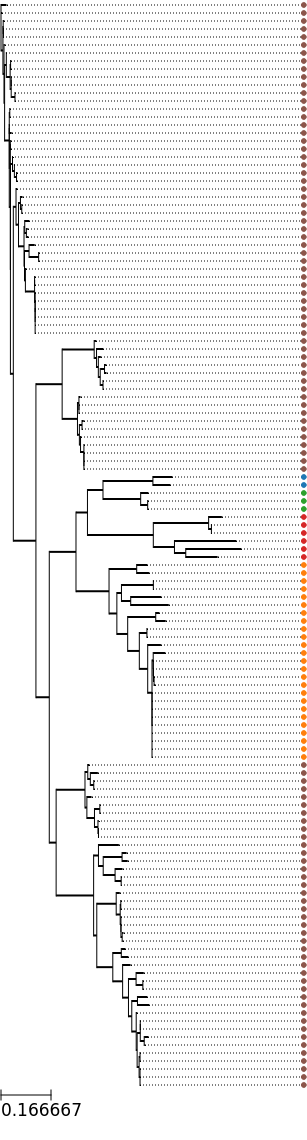

In [59]:
plot_tree(zeqian_tree,zeqian_taxa, colormap=colormap, taxa_level=level,extend=0.2)

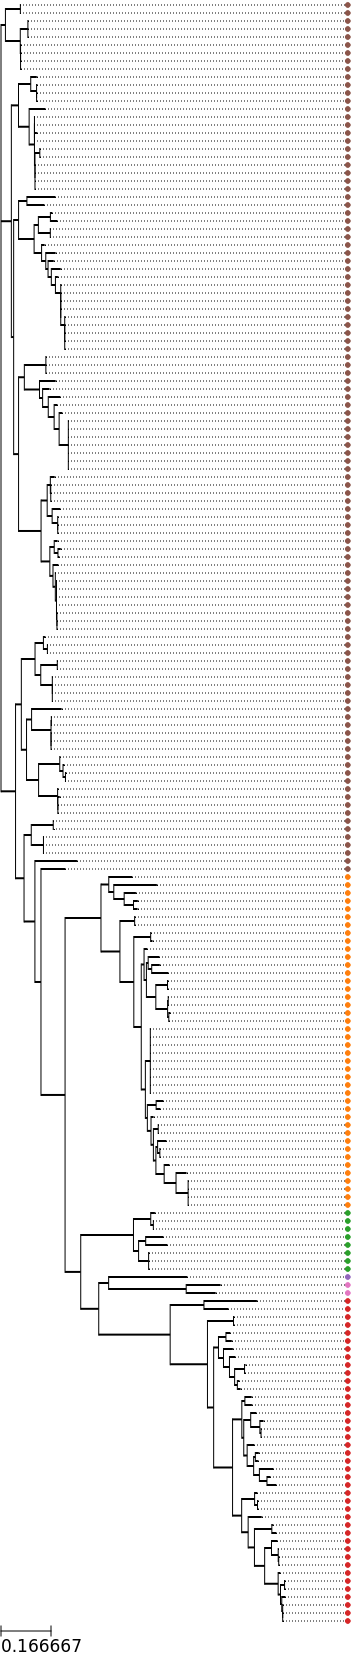

In [60]:
plot_tree(matti_tree,matti_taxa, colormap=colormap, taxa_level=level,extend=0.2)

TODO: color dots plot as legends

## 1B: data overview

ZL, Matti, BacDive data overview; combined tree

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
cmap=ListedColormap(['black','lightgrey','oldlace'])
import seaborn as sns

def plot_growth_data(df):
    df=df.copy()
    fig=plt.figure(figsize=(7,10))
    df[df==1]=2
    df=df.fillna(1)
    sns.heatmap(df,ax=fig.gca(),cmap=cmap, cbar=False,yticklabels=False)
    return fig
    

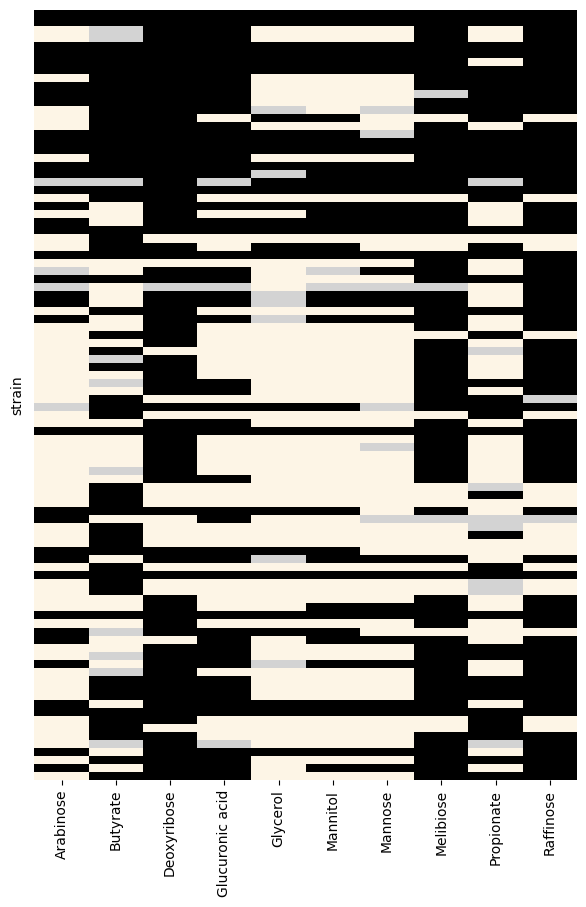

In [13]:
fig=plot_growth_data(pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian.pk")['growth_data'])

In [23]:
import  scipy.cluster.hierarchy as  hierarchy

def cluster_matrix(matrix, axis=0, metric=None, **kwargs):
    """ Hierarchical cluster a matrix. 
    
    """
    if axis == 1:
        return cluster_matrix(matrix.T, axis=0, metric=metric, **kwargs).T

    if metric is None:
        def metric(x, y):
            x = (x > 0).astype(int)
            y = (y > 0).astype(int)
            # -np.logical_and(np.isnan(x),np.isnan(y)).sum())
            return 1-(x == y).sum()/len(x)
    Z = hierarchy.linkage(matrix, metric=metric, **kwargs)

    return matrix.iloc[hierarchy.leaves_list(Z), :]



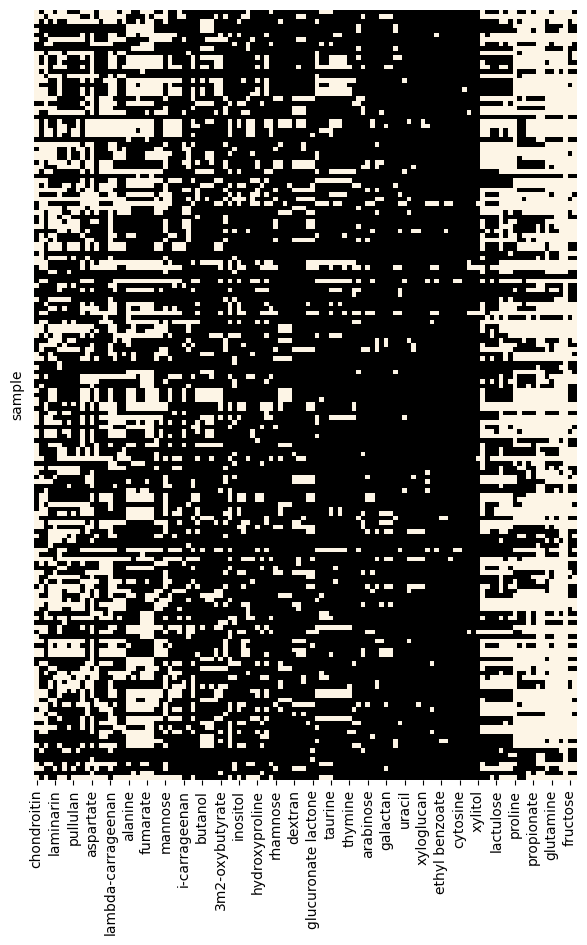

In [24]:
fig=plot_growth_data(cluster_matrix(pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/matti/matti.pk")['growth_data'],axis=1))

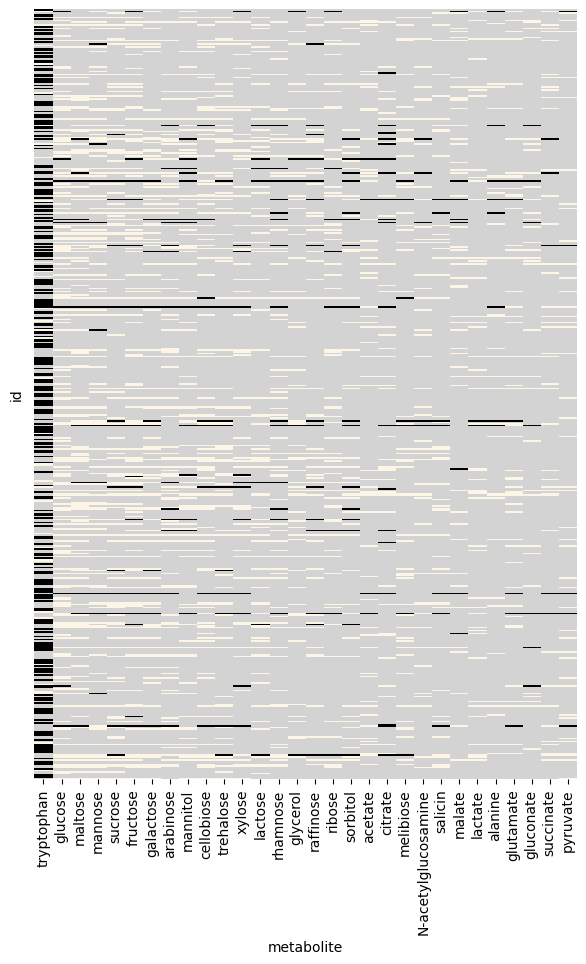

In [17]:
# Bacdive
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")['growth_data']
df=df.iloc[:,np.argsort(df.count(axis=0).values)[::-1]]

fig=plot_growth_data(df.iloc[np.random.choice(df.shape[0],500),:30])